In [320]:
from sklearn.linear_model import ElasticNet
import joblib 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import scipy

import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm_notebook as tqdm
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm

# Prepare data

In [65]:
def predict_tAge(data, model):
    features = model.feature_names
    data_for_calculation = data[features]
    tAge = model.predict(data_for_calculation)
    
    return tAge

def key2key(raw, key, query_key, species):
    import mygene
    mg = mygene.MyGeneInfo()
    query = mg.querymany(raw, scopes=key, species=species, verbose=False)   

    ref2entrez = {r:[] for r in raw}
    for r, q in zip(raw, query):
        if query_key in q:
            ref2entrez[r].append(q[query_key])
        else:
            ref2entrez[r] = None

    print('Max number of ENTREZ across keys:', 
            max([len(ref2entrez[r]) for r in ref2entrez.keys() if ref2entrez[r] is not None]))

    ref2entrez = {k:v[0] for k,v in ref2entrez.items() if (v is not None) and (len(v)==1)}
    return ref2entrez

## Mouse

In [19]:
# from utils.structure import load_structure
# udf = load_structure('data/ultradf_v4.json')

In [57]:
clocks = joblib.load(open('clocks/Aging_mouse_norm.pkl', 'rb'))
data = pd.read_csv('clocks/mouse_exprs_norm_final_29ds.csv', index_col=0)
annot = pd.read_csv('clocks/mouse_data_annotation_29ds.csv', index_col=1)


/home/shappiron/anaconda3/lib/python3.7/site-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator ElasticNet from version 0.24.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [58]:
mouse_clock_age_norm = predict_tAge(data, clocks)
annot['AgeNorm'] = mouse_clock_age_norm
annot = annot.drop('Unnamed: 0', 1)

/home/shappiron/anaconda3/lib/python3.7/site-packages/sklearn/base.py:439: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [59]:
annot.to_csv('clocks/Mouse_clock_output.csv')

## Human

In [54]:
clocks = joblib.load(open('clocks/Aging_human_norm.pkl', 'rb'))
data = pd.read_csv('clocks/human_exprs_norm_final.csv', index_col=0)
annot = pd.read_csv('clocks/human_data_annotation.csv', index_col=1)


/home/shappiron/anaconda3/lib/python3.7/site-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator ElasticNet from version 0.24.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [55]:
human_clock_age_norm = predict_tAge(data, clocks)
annot['AgeNorm'] = human_clock_age_norm
annot = annot.drop('Unnamed: 0', 1)

/home/shappiron/anaconda3/lib/python3.7/site-packages/sklearn/base.py:439: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [56]:
annot.to_csv('clocks/Human_clock_output.csv')

# Explore clocks

In [88]:
#we upload all the data
model = joblib.load(open('clocks/Aging_mouse_norm.pkl', 'rb'))
data = pd.read_csv('clocks/mouse_exprs_norm_final_29ds.csv', index_col=0)
annot = pd.read_csv('clocks/mouse_data_annotation_29ds.csv', index_col="ID")

#mouse aging genes
aging_genes_dataset = pd.read_csv('subdata/gene_atlas_aging.csv')
aging_genes = aging_genes_dataset['Symbol'].tolist()

#pluripotency genes
mouse_pluri = pd.read_csv('subdata/pluripotency_genes_mouse.csv', index_col=0).index
human_pluri = pd.read_csv('subdata/pluripotency_genes_human.csv', index_col=0).index

print("Mouse aging genes %d" % len(aging_genes))
print("Mouse pluripotency genes %d" % (len(mouse_pluri)))
print("Human pluripotency genes %d" % (len(human_pluri)))
print("Mouse|Human intersection of pluripotency genes %d" % (len(mouse_pluri.intersection(human_pluri))))

Mouse aging genes 466
Mouse pluripotency genes 45
Human pluripotency genes 250
Mouse|Human intersection of pluripotency genes 18


In [90]:
#Test model
##sklearn case
pred1 = predict_tAge(data, model)

##all features case
coef = model.coef_
itc = model.intercept_
X = np.array(data[model.feature_names])
pred2 = np.dot(coef, X.T) + itc

##nonzero features case
genes = np.array(model.feature_names)
ids = np.nonzero(coef)[0]
coef = coef[ids]
genes = genes[ids]

X = np.array(data[genes])
pred3 = np.dot(coef, X.T) + itc

print("Manual prediction works:", np.all(np.isclose(pred1, pred2)))
print("Manual prediction works with nonzero features:", np.all(np.isclose(pred1, pred3)))

Manual prediction works: True
Manual prediction works with nonzero features: True


In [135]:
#create dataframe of coefficients
raw = genes.tolist()
etz = key2key(raw, 'entrezgene', 'symbol', 'mouse')
genesym = np.array([etz[k] for k in raw])
ids_sort = np.argsort(coef)[::-1]
coef_sort = coef[ids_sort]
gene_sort = genesym[ids_sort]

wei = pd.DataFrame({'coef':coef_sort, 'gene':gene_sort, 'etz':np.array(raw)[ids_sort]})
wei = wei.set_index('gene')

wei_age = wei.index.intersection(aging_genes)
wei_plu_m = wei.index.intersection(mouse_pluri)
wei_plu_h = wei.index.intersection(human_pluri)

print("Intersection nonzero model with aging genes: %d total, " % len(wei_age), wei_age.tolist())
print("Intersection nonzero model with mouse pluri genes: %d total, " % len(wei_plu_m), wei_plu_m.tolist())
print("Intersection nonzero model with human pluri genes: %d total, " % len(wei_plu_h), wei_plu_h.tolist())

Max number of ENTREZ across keys: 1
Intersection nonzero model with aging genes: 18 total,  ['Egr1', 'Adcy3', 'Itpr3', 'Efemp1', 'Cbx7', 'Bmp2', 'Sesn2', 'Bmp6', 'Gadd45a', 'Cacna1a', 'Fos', 'Gadd45g', 'Jun', 'Adcy7', 'Mmp9', 'Ptges', 'Sesn1', 'Igfbp3']
Intersection nonzero model with mouse pluri genes: 1 total,  ['Alpl']
Intersection nonzero model with human pluri genes: 6 total,  ['Med19', 'Klf4', 'Cnot3', 'Id2', 'Hspb1', 'Ezh2']


In [405]:
#check effect of pluripotency genes knocking out.

knockout = ['Lyz2']#['Alpl', 'Ezh2', 'Med19', 'Klf4', 'Cnot3', 'Id2', 'Hspb1', 'Alpl',] #'Ezh2',
wei_tmp = wei.copy()
wei_tmp.loc[knockout, 'coef'] = 0
coef_modified = wei_tmp.coef.values
itc = model.intercept_

effects = {}
for ds in tqdm(annot.Dataset.unique()):
    sub_id = annot[annot.Dataset == ds].index
    sub_time = annot[annot.Dataset == ds].Time
    sub_data = data.loc[sub_id]
    sub_X = np.array(data.loc[sub_id][wei.etz.values])

    ground_pred = predict_tAge(sub_data, model)
    lm = scipy.stats.linregress(sub_time, ground_pred)
    new_pred = np.dot(coef_modified, sub_X.T) + itc
    
    if lm.slope > 0:
        continue
    
    test = scipy.stats.mannwhitneyu(ground_pred, new_pred)
    pval = test.pvalue
    pval_str = np.format_float_scientific(pval, 3)

    effects[ds] = {}
    effects[ds]['ds_pval'] = lm.pvalue
    effects[ds]['time'] = sub_time
    effects[ds]['gnd'] = ground_pred
    effects[ds]['npl'] = new_pred
    effects[ds]['pval'] = pval
    effects[ds]['pval_str'] = pval_str
    effects[ds]['max_effect'] = max(abs(new_pred - ground_pred)) / max(ground_pred) * 100

passed = multipletests([v['ds_pval'] for k,v in effects.items()], 0.01, method='fdr_bh')[0]
effects = {k:v for (k,v), p in zip(effects.items(), passed) if p }


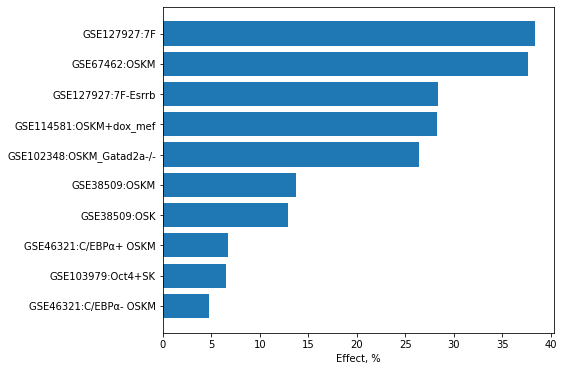

In [406]:
#plot significance of rejuvenation
D, M = list(zip(*[(k, v['max_effect']) for k,v in effects.items()])) #get pvals
D, M = list(zip(*[(x, y) for y,x in sorted(zip(M, D))])) #sort pvals

thr = 0.05
plt.figure(figsize=(7,6))
plt.barh(D, M)
plt.xlabel('Effect, %')
plt.show()

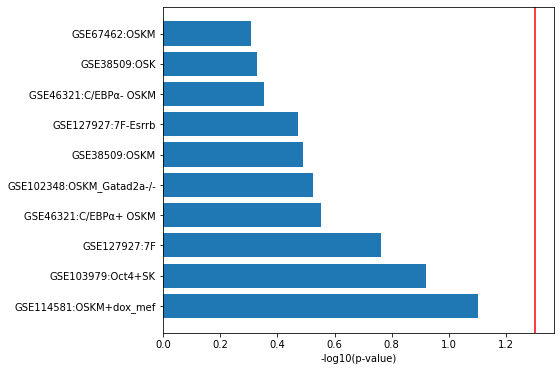

In [407]:
#plot significance of rejuvenation
D, P = list(zip(*[(k, v['pval']) for k,v in effects.items()])) #get pvals
D, P = list(zip(*[(x, y) for y,x in sorted(zip(P, D))])) #sort pvals

thr = 0.05
plt.figure(figsize=(7,6))
plt.barh(D, -np.log10(P))
plt.axvline(-np.log10(thr), color='red')
plt.xlabel('-log10(p-value)')   
plt.show()

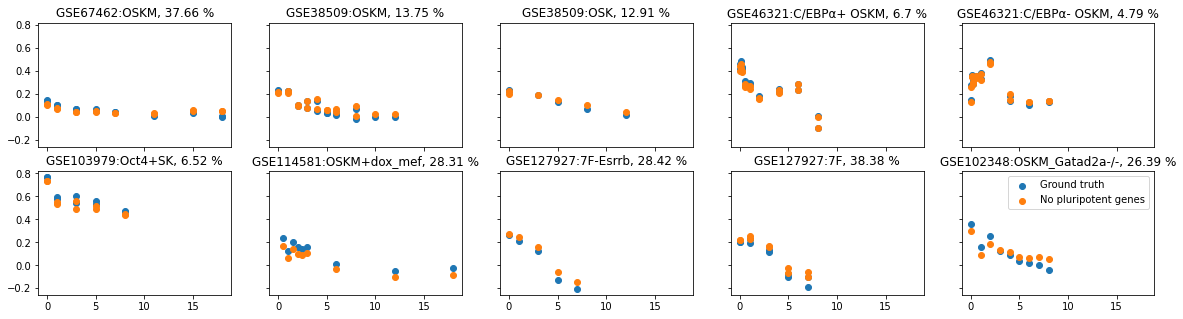

In [408]:
fig, axes = plt.subplots(2, 5, figsize=(20, 5), sharex=True, sharey=True)
for ax, (ds, v) in zip(axes.flatten(), effects.items()):
    sub_time = effects[ds]['time']
    ground_pred = effects[ds]['gnd']
    new_pred = effects[ds]['npl']
    pval = v['pval']

    max_effect = max(abs(new_pred - ground_pred)) / max(ground_pred) * 100
    
    ax.set_title("%s, %s %%" % (ds, str(round(max_effect, 2))))
    ax.scatter(sub_time, ground_pred, label='Ground truth')
    ax.scatter(sub_time, new_pred, label='No pluripotent genes')
plt.legend()

In [361]:
def fit_lm(sub_time, new_pred, ground_pred):
    sub_time_ = sm.add_constant(sub_time, prepend=True)
    mod = sm.OLS(new_pred - ground_pred, sub_time_)
    res = mod.fit()
    itc_m, slope_m = res.params.loc['const'], res.params.loc['Time']
    itc_p, slope_p = res.pvalues.loc['const'], res.pvalues.loc['Time']
    return itc_m, slope_m, itc_p, slope_p

In [368]:
#Check effects for all genes
approved_datasets = list(effects.keys())
gene_effects = pd.DataFrame()
for g in tqdm(wei.index.tolist()):
    knockout = [g]
    wei_tmp = wei.copy()
    wei_tmp.loc[knockout, 'coef'] = 0
    coef_modified = wei_tmp.coef.values
    itc = model.intercept_

    for ds in approved_datasets:
        sub_id = annot[annot.Dataset == ds].index
        sub_time = annot[annot.Dataset == ds].Time
        sub_data = data.loc[sub_id]
        sub_X = np.array(data.loc[sub_id][wei.etz.values])

        ground_pred = predict_tAge(sub_data, model)
        new_pred = np.dot(coef_modified, sub_X.T) + itc
        itc_m, slope_m, itc_p, slope_p = fit_lm(sub_time, new_pred, ground_pred)

        gene_effects = gene_effects.append(pd.Series({"const":itc_m, "slope":slope_m, 
                                                      "p_const":itc_p, "p_slope":slope_p,
                                                      "dataset":ds}, 
                                                      name=g))

#passed = multipletests([v['ds_pval'] for k,v in effects.items()], 0.01, method='fdr_bh')[0]
#effects = {k:v for (k,v), p in zip(effects.items(), passed) if p }


In [376]:
gene_effects['dataset'] = np.array(approved_datasets * len(wei))

In [379]:
gene_effects['pass_const'] = multipletests(gene_effects['p_const'] , 0.05, method='fdr_bh')[0]
gene_effects['pass_slope'] = multipletests(gene_effects['p_slope'] , 0.05, method='fdr_bh')[0]

In [381]:
gef = gene_effects

In [399]:
#gef.to_csv('tmp/gef.csv')

In [409]:
su = gef[(gef.dataset=='GSE67462:OSKM') & \
        ((gef.pass_const==True) | (gef.pass_slope==True)) & \
        (gef.const > 0)]

In [411]:
su.sort_values('const')

,const,p_const,p_slope,slope,dataset,pass_const,pass_slope
Casp6,0.000002,1.319000e-02,6.970373e-01,-3.167647e-08,GSE67462:OSKM,True,False
Lrrk2,0.000026,1.331420e-05,4.137027e-07,-3.574417e-06,GSE67462:OSKM,True,True
Prkrip1,0.000041,7.595643e-03,2.075347e-01,-1.796778e-06,GSE67462:OSKM,True,False
Zfp759,0.000093,2.438609e-07,6.624294e-01,-4.641619e-07,GSE67462:OSKM,True,False
Cirbp,0.000098,1.082654e-01,2.085300e-03,-2.217902e-05,GSE67462:OSKM,False,True
...,...,...,...,...,...,...,...
Postn,0.029931,7.693907e-12,1.704802e-02,-4.070063e-04,GSE67462:OSKM,True,False
Clec7a,0.031072,1.607044e-14,8.720538e-01,1.633177e-05,GSE67462:OSKM,True,False
Fn1,0.032665,2.853705e-19,5.110954e-01,3.215071e-05,GSE67462:OSKM,True,False
Ezh2,0.055118,2.233382e-19,8.777657e-03,2.405258e-04,GSE67462:OSKM,True,True
